# Predictive QSAR model

In [ ]:
# This version of the library was chosen to enable further implementation of the predictive model in FREED++
!pip install scikit-learn==1.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.15.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.


In [2]:
# Import necessary libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

import joblib
from tqdm.notebook import tqdm

In [ ]:
# Reading data
df = pd.read_csv('/content/drive/MyDrive/статья/Data/df_fp.csv')

In [ ]:
def evaluate_metrics(y_true, y_pred):
    '''
    Function for evaluating model metrics.
    MSE and R-squared were chosen as important metrics.
    '''
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, r2

## Testing base models

In [ ]:
random_states = [42, 140, 456, 789, 1011]

models = {
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(),
}

for model_name, model in models.items():
    print(f"Model: {model_name}")

    mse_train_scores = []
    r2_train_scores = []
    mse_test_scores = []
    r2_test_scores = []

    for random_state in random_states:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

        model.set_params(random_state=random_state)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        mse_train, r2_train = evaluate_metrics(y_train, y_train_pred)
        mse_train_scores.append(mse_train)
        r2_train_scores.append(r2_train)

        y_test_pred = model.predict(X_test)
        mse_test, r2_test = evaluate_metrics(y_test, y_test_pred)
        mse_test_scores.append(mse_test)
        r2_test_scores.append(r2_test)

    print('Train set metrics (mean +- std):')
    print(f"MSE: {np.mean(mse_train_scores):.3f} (+- {np.std(mse_train_scores):.3f}), R2: {np.mean(r2_train_scores):.3f} (+- {np.std(r2_train_scores):.3f})")

    print('Test set metrics (mean +- std):')
    print(f"MSE: {np.mean(mse_test_scores):.3f} (+- {np.std(mse_test_scores):.3f}), R2: {np.mean(r2_test_scores):.3f} (+- {np.std(r2_test_scores):.3f})")

    print("-" * 50)

Model: HistGradientBoostingRegressor
Train set metrics (mean +- std):
MSE: 0.158 (+- 0.003), R2: 0.874 (+- 0.002)
Test set metrics (mean +- std):
MSE: 0.351 (+- 0.021), R2: 0.720 (+- 0.013)
--------------------------------------------------
Model: RandomForestRegressor
Train set metrics (mean +- std):
MSE: 0.056 (+- 0.002), R2: 0.955 (+- 0.001)
Test set metrics (mean +- std):
MSE: 0.351 (+- 0.021), R2: 0.719 (+- 0.014)
--------------------------------------------------
Model: XGBRegressor
Train set metrics (mean +- std):
MSE: 0.089 (+- 0.003), R2: 0.928 (+- 0.002)
Test set metrics (mean +- std):
MSE: 0.358 (+- 0.019), R2: 0.714 (+- 0.012)
--------------------------------------------------


In [ ]:
model = SVR()
mse_train_scores = []
r2_train_scores = []
mse_test_scores = []
r2_test_scores = []

for random_state in random_states:

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

      model.fit(X_train, y_train)

      y_train_pred = model.predict(X_train)
      mse_train, r2_train = evaluate_metrics(y_train, y_train_pred)
      mse_train_scores.append(mse_train)
      r2_train_scores.append(r2_train)

      y_test_pred = model.predict(X_test)
      mse_test, r2_test = evaluate_metrics(y_test, y_test_pred)
      mse_test_scores.append(mse_test)
      r2_test_scores.append(r2_test)

print('Train set metrics (mean +- std):')
print(f"MSE: {np.mean(mse_train_scores):.3f} (+- {np.std(mse_train_scores):.3f}), R2: {np.mean(r2_train_scores):.3f} (+- {np.std(r2_train_scores):.3f})")

print('Test set metrics (mean +- std):')
print(f"MSE: {np.mean(mse_test_scores):.3f} (+- {np.std(mse_test_scores):.3f}), R2: {np.mean(r2_test_scores):.3f} (+- {np.std(r2_test_scores):.3f})")

print("-" * 50)

Train set metrics (mean +- std):
MSE: 0.159 (+- 0.003), R2: 0.873 (+- 0.002)
Test set metrics (mean +- std):
MSE: 0.346 (+- 0.016), R2: 0.724 (+- 0.007)
--------------------------------------------------


## Hyperparameter optimization

The hyperparameters were selected using a library **Optuna**, the code can be found in the file `hyperparameter_tuning.py`. Here is an evaluation of models with selected hyperparameters

In [ ]:
# Division into training and test datasets
X = df.drop(['Smiles', 'pIC50'], axis=1)
y = df['pIC50']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=140)

In [ ]:
random_states = [42, 140, 456, 789, 1011]

models = {
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor(
        max_depth=10,
        learning_rate=0.28281638841802814,
        max_leaf_nodes=20,
        max_bins=143,
        l2_regularization=0.6095585718861447
    ),
    'RandomForestRegressor': RandomForestRegressor(
        n_estimators=539,
        max_depth=28,
        min_samples_split=10,
        min_samples_leaf=2,
        max_features=0.5,
        bootstrap=True,
        max_leaf_nodes=100,
        min_impurity_decrease=0.0004960821377972546
    ),
    'XGBRegressor': XGBRegressor(
        n_estimators=1000,
        max_depth=7,
        learning_rate=0.11501682796985016,
        gamma=0.013803874931246955,
        min_child_weight=0.00010032843656789144,
        subsample=0.9154426484135898,
        colsample_bytree=0.8051696449848995,
        reg_alpha=0.037709908283080865,
        reg_lambda=9.202239129257975
    )
}

for model_name, model in models.items():
    print(f"Model: {model_name}")

    mse_train_scores = []
    r2_train_scores = []
    mse_test_scores = []
    r2_test_scores = []

    for random_state in random_states:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

        if hasattr(model, 'random_state'):
            model.set_params(random_state=random_state)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        mse_train, r2_train = evaluate_metrics(y_train, y_train_pred)
        mse_train_scores.append(mse_train)
        r2_train_scores.append(r2_train)

        y_test_pred = model.predict(X_test)
        mse_test, r2_test = evaluate_metrics(y_test, y_test_pred)
        mse_test_scores.append(mse_test)
        r2_test_scores.append(r2_test)

    print('Train set metrics (mean +- std):')
    print(f"MSE: {np.mean(mse_train_scores):.3f} (+- {np.std(mse_train_scores):.3f}), R2: {np.mean(r2_train_scores):.3f} (+- {np.std(r2_train_scores):.3f})")

    print('Test set metrics (mean +- std):')
    print(f"MSE: {np.mean(mse_test_scores):.3f} (+- {np.std(mse_test_scores):.3f}), R2: {np.mean(r2_test_scores):.3f} (+- {np.std(r2_test_scores):.3f})")

    print("-" * 50)

Model: HistGradientBoostingRegressor
Train set metrics (mean +- std):
MSE: 0.134 (+- 0.004), R2: 0.892 (+- 0.003)
Test set metrics (mean +- std):
MSE: 0.357 (+- 0.012), R2: 0.715 (+- 0.008)
--------------------------------------------------
Model: RandomForestRegressor
Train set metrics (mean +- std):
MSE: 0.239 (+- 0.002), R2: 0.809 (+- 0.001)
Test set metrics (mean +- std):
MSE: 0.393 (+- 0.020), R2: 0.686 (+- 0.009)
--------------------------------------------------
Model: XGBRegressor
Train set metrics (mean +- std):
MSE: 0.024 (+- 0.003), R2: 0.981 (+- 0.002)
Test set metrics (mean +- std):
MSE: 0.322 (+- 0.019), R2: 0.743 (+- 0.011)
--------------------------------------------------


In [ ]:
model = SVR(
    C=4.709477617282304,
    kernel='rbf',
    epsilon=0.007570594716998358,
    gamma='scale'
)
mse_train_scores = []
r2_train_scores = []
mse_test_scores = []
r2_test_scores = []

for random_state in random_states:

      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

      model.fit(X_train, y_train)

      y_train_pred = model.predict(X_train)
      mse_train, r2_train = evaluate_metrics(y_train, y_train_pred)
      mse_train_scores.append(mse_train)
      r2_train_scores.append(r2_train)

      y_test_pred = model.predict(X_test)
      mse_test, r2_test = evaluate_metrics(y_test, y_test_pred)
      mse_test_scores.append(mse_test)
      r2_test_scores.append(r2_test)

print('Train set metrics (mean +- std):')
print(f"MSE: {np.mean(mse_train_scores):.3f} (+- {np.std(mse_train_scores):.3f}), R2: {np.mean(r2_train_scores):.3f} (+- {np.std(r2_train_scores):.3f})")

print('Test set metrics (mean +- std):')
print(f"MSE: {np.mean(mse_test_scores):.3f} (+- {np.std(mse_test_scores):.3f}), R2: {np.mean(r2_test_scores):.3f} (+- {np.std(r2_test_scores):.3f})")

print("-" * 50)

Train set metrics (mean +- std):
MSE: 0.026 (+- 0.004), R2: 0.979 (+- 0.003)
Test set metrics (mean +- std):
MSE: 0.303 (+- 0.018), R2: 0.758 (+- 0.013)
--------------------------------------------------


### Meta-regressor

For base models, we selected the top-performing algorithms from our initial analysis: SVR, XGBoost and RandomForestRegressor. A standard linear regression model was employed as the final estimator in the stacking ensemble.

Hyperparameter optimization is presented in the file `stacking_tuning.py`.


In [ ]:
base_models = [
    ('rfr', RandomForestRegressor(
        n_estimators=754,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=11,
        max_features="log2",
        bootstrap=False,
        max_leaf_nodes=18,
        min_impurity_decrease=0.0011458673389399172
    )),
    ('svr', SVR(
        C=5.4247429203374695,
        epsilon=0.0010304271925661898,
        kernel="rbf",
        gamma="scale"
    )),
    ('XGBRegressor', XGBRegressor(
        n_estimators=1000,
        max_depth=7,
        learning_rate=0.11501682796985016,
        gamma=0.013803874931246955,
        min_child_weight=0.00010032843656789144,
        subsample=0.9154426484135898,
        colsample_bytree=0.8051696449848995,
        reg_alpha=0.037709908283080865,
        reg_lambda=9.202239129257975
    ))
]

meta_model = LinearRegression()

# Creating a stacking regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

In [ ]:
mse_train_scores = []
r2_train_scores = []
mse_test_scores = []
r2_test_scores = []

for random_state in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    if hasattr(stacking_regressor, 'random_state'):
        stacking_regressor.set_params(random_state=random_state)
    stacking_regressor.fit(X_train, y_train)

    y_train_pred = stacking_regressor.predict(X_train)
    mse_train, r2_train = evaluate_metrics(y_train, y_train_pred)
    mse_train_scores.append(mse_train)
    r2_train_scores.append(r2_train)

    y_test_pred = stacking_regressor.predict(X_test)
    mse_test, r2_test = evaluate_metrics(y_test, y_test_pred)
    mse_test_scores.append(mse_test)
    r2_test_scores.append(r2_test)

print('Train set metrics (mean +- std):')
print(f"MSE: {np.mean(mse_train_scores):.3f} (+- {np.std(mse_train_scores):.3f}), R2: {np.mean(r2_train_scores):.3f} (+- {np.std(r2_train_scores):.3f})")

print('Test set metrics (mean +- std):')
print(f"MSE: {np.mean(mse_test_scores):.3f} (+- {np.std(mse_test_scores):.3f}), R2: {np.mean(r2_test_scores):.3f} (+- {np.std(r2_test_scores):.3f})")

print("-" * 50)

Train set metrics (mean +- std):
MSE: 0.023 (+- 0.003), R2: 0.982 (+- 0.003)
Test set metrics (mean +- std):
MSE: 0.299 (+- 0.015), R2: 0.761 (+- 0.011)
--------------------------------------------------


## Saving the final model (with best metrics)

In [ ]:
X = df.drop(['Smiles', 'pIC50'], axis=1)
y = df['pIC50']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=456)

In [ ]:
base_models = [
    ('rfr', RandomForestRegressor(
        n_estimators=754,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=11,
        max_features="log2",
        bootstrap=False,
        max_leaf_nodes=18,
        min_impurity_decrease=0.0011458673389399172
    )),
    ('svr', SVR(
        C=5.4247429203374695,
        epsilon=0.0010304271925661898,
        kernel="rbf",
        gamma="scale"
    )),
    ('XGBRegressor', XGBRegressor(
        n_estimators=1000,
        max_depth=7,
        learning_rate=0.11501682796985016,
        gamma=0.013803874931246955,
        min_child_weight=0.00010032843656789144,
        subsample=0.9154426484135898,
        colsample_bytree=0.8051696449848995,
        reg_alpha=0.037709908283080865,
        reg_lambda=9.202239129257975
    ))
]

meta_model = LinearRegression()

# Creating a stacking regressor
model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

# Stacking Regressor Training
model.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('rfr',
                               RandomForestRegressor(bootstrap=False,
                                                     max_depth=10,
                                                     max_features='log2',
                                                     max_leaf_nodes=18,
                                                     min_impurity_decrease=0.0011458673389399172,
                                                     min_samples_leaf=11,
                                                     min_samples_split=5,
                                                     n_estimators=754)),
                              ('svr',
                               SVR(C=5.4247429203374695,
                                   epsilon=0.0010304271925661898)),
                              ('XGBRegressor',
                               XGBRegressor(base_score=None, booster...
                                            learning_r

In [ ]:
print('Metrics for train set:')
y_train_pred = model.predict(X_train)
mse_train, r2_train = evaluate_metrics(y_train, y_train_pred)
print(f"MSE: {mse_train:.3f}, R2: {r2_train:.3f}")

print('Metrics for test set:')
y_pred = model.predict(X_test)
mse, r2 = evaluate_metrics(y_test, y_pred)
print(f"MSE: {mse:.3f}, R2: {r2:.3f}")

Metrics for train set:
MSE: 0.027, R2: 0.978
Metrics for test set:
MSE: 0.273, R2: 0.776


In [ ]:
joblib.dump(model, '/content/drive/MyDrive/статья/Models/stacking_regressor.joblib')

['/content/drive/MyDrive/статья/Models/stacking_regressor_12_09.joblib']

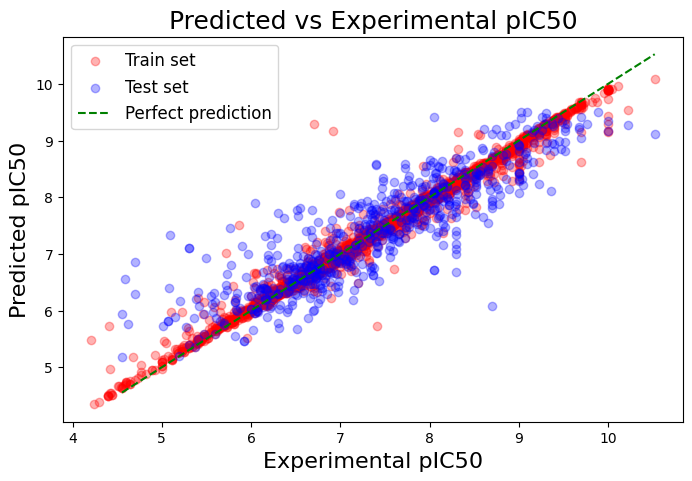

In [ ]:
#  Scatter plot of model on the train and test sets
plt.figure(figsize=(8, 5))

plt.scatter(y_train, y_train_pred, color='red', alpha=0.3, label='Train set')

plt.scatter(y_test, y_pred, color='blue', alpha=0.3, label='Test set')

# Perfect prediction y = x
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='green', linestyle='--', label='Perfect prediction')

plt.title('Predicted vs Experimental pIC50', fontsize=18)
plt.xlabel('Experimental pIC50', fontsize=16)
plt.ylabel('Predicted pIC50', fontsize=16)

plt.legend(fontsize=12)

plt.grid(False)

plt.show()